# 1. Load Required Packages

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import sys
import csv
%matplotlib inline

In [ ]:
try:
    if (sys.argv[1] == '-'):
        f = sys.stdin.read().splitlines()
    else:
        filename = sys.argv[1]
        f = open(filename, 'r')
    data = csv.reader(f)
except Exception, e:
    print "Error Reading from file:"

# 2. Import the Data-Set

In [40]:
cars  = pd.read_csv("data.csv")

In [41]:
cars.head()

,car_company,model_ID,mileage,engine_power,registration_date,fuel,car_paint_color,car_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,sold_date,car_price
0,Edureka_motors,318 Gran Turismo,140245,105,01-10-2014,diesel,white,hatchback,False,True,False,False,True,True,True,True,01-03-2018,19200
1,Edureka_motors,218 Active Tourer,91512,100,01-06-2015,petrol,white,van,False,True,True,False,False,False,True,False,01-05-2018,14300
2,Edureka_motors,318,113744,100,01-06-2012,diesel,grey,sedan,True,True,False,False,False,False,True,False,01-06-2018,14300
3,Edureka_motors,320 Gran Turismo,195063,135,01-05-2014,diesel,black,hatchback,False,True,True,False,True,False,True,True,01-03-2018,16200
4,Edureka_motors,518,148943,100,01-11-2013,diesel,brown,estate,True,True,True,False,True,False,True,True,01-05-2018,17300


# 3. Data Pre-processing

a. (sold_date - registration_date) tells us how old the car is Let's add the column "car_age_days" to the data set.

In [42]:
cars['sold_date'] = pd.to_datetime(cars['sold_date'])
cars['registration_date'] = pd.to_datetime(cars['registration_date'])



In [43]:
cars['car_age_days'] = cars['sold_date'] - cars['registration_date']

So, we have added the column 'car_age_days' to the dataset.

b. Let's convert car_age_days to categorical values to simplify analysys later.

In [44]:
def simplify_car_age(element):
    if element <= pd.to_timedelta('365 days'):
        return 'New'
    elif element >  pd.to_timedelta('365 days') and element <=  pd.to_timedelta('1460 days'):
        return 'Little_Old'
    elif element >  pd.to_timedelta('1460 days') and element <=  pd.to_timedelta('2920 days'):
        return "Old"
    elif element > pd.to_timedelta('2920 days'):
        return 'Very_Old'
cars['age_simplified'] = cars['car_age_days'].apply(simplify_car_age)

Now age_simplified column contains four categories which are:
1. New       : < 1 Yr old
2. Little_old: 2-4 Yr old
3. old       : 4-8 Yr old
4. Very_old  : >8  Yr old

b. Let's Map model_ID column values to Four categories for easier analysis.

In [45]:
def convert_to_cat(element):
    if element.isnumeric() :
        return "Three_digit_model"
    elif 'Gran' in element:
        return "Gran_model"
    elif 'Active' in element:
        return "Active_model"
    elif 'X' in element:
        return "X_model"
cars['model_cat'] = cars['model_ID'].apply(convert_to_cat)
cars.drop(columns = 'model_ID',axis = 1 , inplace = True)

Now model_cat contains four categories which are:
1. "Three_digit_model" : if model_id is just 3 digit number
2. "Gran_model"        : if model_id contains Gran in it.
3. "Active_model"      : if model_id contains Active in it.
4. 'X_model'           : id model_id contains X_model in it.

c. "car_company" is pretty redundant column we can drop it.

In [46]:
cars.drop(columns = 'car_company',axis = 1 , inplace = True)

# 4. Data Exploration(EDA)

We will use Scatter plots to find any ouliers if present!

a.) car_price Vs engine_power

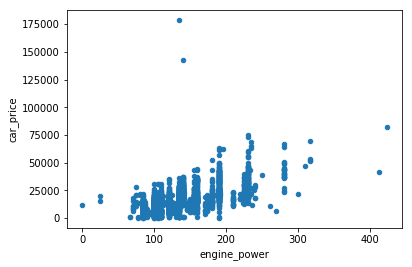

In [47]:
cars['car_price'].astype('float')
cars.plot(kind = 'scatter' , x = 'engine_power', y = 'car_price')

They are strongly correlated. we can see some outliers so we better drop those rows other wise they will effect our model performance.

In [48]:
cars.loc[cars['car_price'] > 100000,'car_price'] = np.NaN
cars.dropna(subset = ['car_price'],axis = 0,inplace = True)


b.) car_price Vs mileage

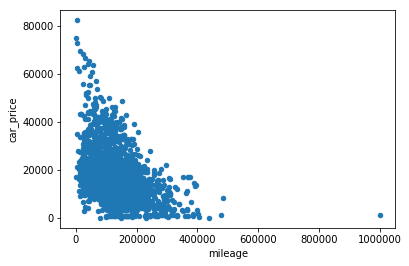

In [49]:
cars.plot(kind = 'scatter' , x = 'mileage', y = 'car_price')

There is an outlier here as well so we better drop that row as well.

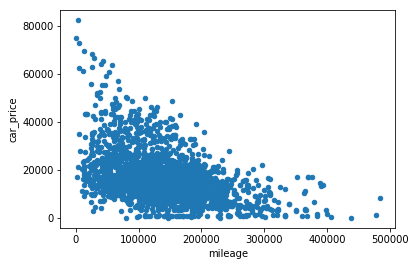

In [50]:
cars.loc[cars['mileage'] > 800000,'mileage'] = np.NaN
cars.dropna(subset = ['mileage'], axis = 0, inplace = True)
cars.plot(kind = 'scatter' , x = 'mileage', y = 'car_price')

Looks like we have a strong negative correleation between car_price and mileage.

Idea : if any feature has most of the values same then it is not a strong feature and dropping it will not have any
effect on performance.

In [51]:
f_list = ['feature1','feature2','feature3','feature4','feature5','feature6','feature7','feature8']
    
cars[f_list].sum()

feature1    1868
feature2    2696
feature3     669
feature4     665
feature5    1550
feature6     820
feature7    3157
feature8    1803
dtype: int64

In [52]:
cars.shape

(3387, 19)

 Feature7 seems redundant as it contains 3157 True values out of 3387 so its redundant so we drop that column.

In [53]:
cars.drop(columns = ['feature7'],axis = 1,inplace = True)

# Let's check out  fuel,car_paint_color,car_type columns

Question_1: which is the most popular fuel type ?

In [54]:
cars['fuel'].value_counts()

diesel           3236
petrol            142
hybrid_petrol       6
electro             3
Name: fuel, dtype: int64

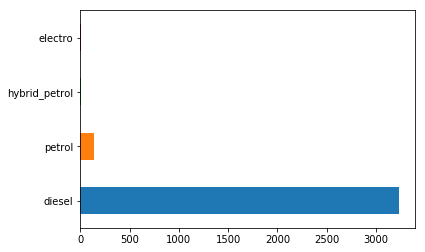

In [55]:
cars['fuel'].value_counts().plot(kind = 'barh')

Ans_1: 95% of the car fuel types are diesel.

Question_2: which of the fuel type car is most expensive and which fuel type is lease expensive?

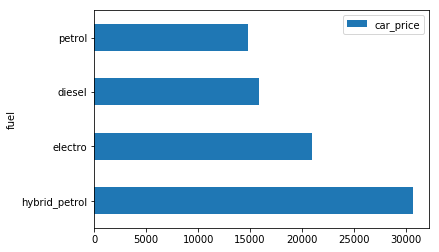

In [56]:
mean_price_fuel = pd.pivot_table(cars, index = 'fuel' , values = 'car_price')
mean_price_fuel.sort_values(by= 'car_price',ascending  = False).plot(kind = 'barh')

Ans_2 : Hybrid_petrol fuel type car is the most expensive car and petrol fuel type is least expensive.

Question_3 : Does colour of a car have any impact on the car_price?

In [57]:
cars['car_paint_color'].value_counts()

black     1152
grey       794
blue       505
white      386
silver     234
brown      223
red         38
beige       36
green       14
orange       5
Name: car_paint_color, dtype: int64



Yes, May be an odd coloured car like pink go for a lesser price than normal colours like black,grey e.t.c

In [58]:
mean_colour_fuel = pd.pivot_table(cars, index = 'car_paint_color' , values = 'car_price')
mean_colour_fuel.sort_values(by= 'car_price',ascending  = False)

,car_price
car_paint_color,
orange,17980.000000
white,17579.792746
red,17018.421053
black,16258.940972
brown,15956.502242
beige,15380.555556
grey,15246.473552
silver,15164.957265
blue,14801.188119


Ans_3: According to the data orange coloured car is most expensive and green colored car is least expensive.
But color does not impact car price strongly. For e.g You have same car but with different colour.The prices vary very little.


Question_4: Which car_type is most expensive and which is least on average?

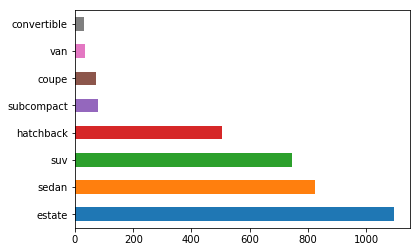

In [59]:
cars['car_type'].value_counts().plot('barh')

Estate is the most popular car type!

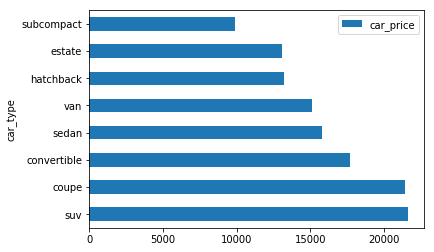

In [60]:
mean_car_type = pd.pivot_table(cars, index = 'car_type' , values = 'car_price')
mean_car_type.sort_values(by= 'car_price',ascending  = False).plot(kind = 'barh')

Ans_4: On average an SUV costs most followed by coupe and convertible!

Question_5: Which car model costs the highest on average

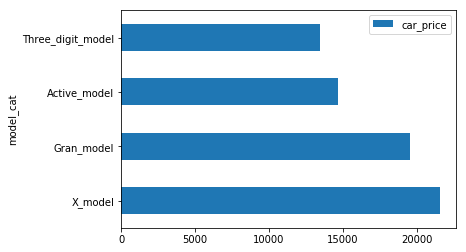

In [61]:
mean_car_model = pd.pivot_table(cars, index = 'model_cat' , values = 'car_price')
mean_car_model.sort_values(by= 'car_price',ascending  = False).plot(kind = 'barh')

Ans_5: On average X_model costs most followed by Gran_model and Active_model

Question_6 : what is the age of most of the cars in the data?

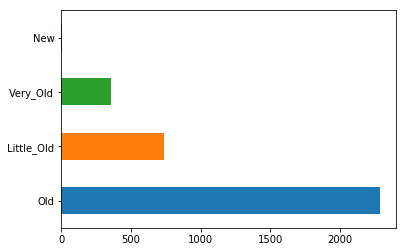

In [62]:
cars['age_simplified'].value_counts().plot(kind = 'barh')

Ans_6 : Most of cars age is "Old" (2-4)Years old.

Question_7: What is the average price of each car_age category(New,little_old,old,very_old)

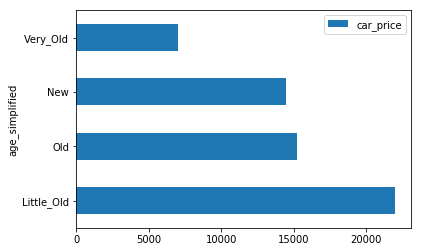

In [63]:
mean_car_age_price = pd.pivot_table(cars, index = 'age_simplified' , values = 'car_price')
mean_car_age_price.sort_values(by= 'car_price',ascending  = False).plot(kind = 'barh')

Ans_7: On Averge a car that is 2-4 years old('Little_old') is the costs more and car which is greater than 8 years('Very_Old') costs least.

# 5. Data Modelling 

Machine can understand only numbers so we have to convert those categorical values to numerical values.

Let's convert columns with categorical values to numerical using One-hot encoding.

In [64]:
dummy_df = pd.get_dummies(cars,columns = ['car_type','fuel','model_cat','feature1','feature2','feature3','feature4','feature5','feature6','feature8','age_simplified'])

we drop Non-numerical columns and prepare our data for modelling.

In [65]:
model_df = dummy_df.drop(columns = ['car_paint_color','registration_date','sold_date','car_age_days'],axis = 1)

In [66]:
Y = model_df['car_price']
X = model_df.drop(columns = ['car_price'],axis = 1)

Model_1: Linear Regression

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)
lm = LinearRegression()
lm.fit(x_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# 6. Model Predictions(Linear Regression)

In [88]:
Yhat=lm.predict(x_train)
Yhat[0:5] 

array([ 8286.13664858,  9664.02544099,  -105.20664293, 19840.81099021,
        8873.92627532])

In [89]:
lm.intercept_

10923.621840784128

In [90]:
lm.coef_

array([-3.67349109e-02,  1.02146870e+02,  1.65871241e+03,  1.75460259e+03,
       -1.65086727e+03, -7.31009587e+02,  3.37988965e+02,  1.70358114e+02,
        2.11070429e+03, -3.65048950e+03, -2.59645044e+03,  1.70552976e+03,
        5.68106395e+03, -4.79014327e+03,  1.69875881e+02,  5.97291808e+02,
       -1.16496517e+03, -1.36577027e+03, -6.26211879e+02,  6.26211880e+02,
       -7.08832082e+02,  7.08832082e+02, -5.06294725e+02,  5.06294725e+02,
       -8.21398913e+02,  8.21398913e+02,  5.66280566e+01, -5.66280565e+01,
       -4.07230950e+02,  4.07230950e+02, -7.17344416e+02,  7.17344416e+02,
        4.29617895e+03, -1.40677487e+03,  9.77180712e+02, -3.86658480e+03])

In [91]:
print('The R-square of train data is: ', lm.score(x_train, y_train))

The R-square of train data is:  0.7456099370960487


In [92]:
mse = mean_squared_error(y_train, Yhat)
print('The mean square error of price and predicted value is: ', mse)

The mean square error of price and predicted value is:  18583009.992220502


# 7. Model Evaluation(Linear Regression)

Distribution plot between train data and predicted data

C:\Users\Welcome\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


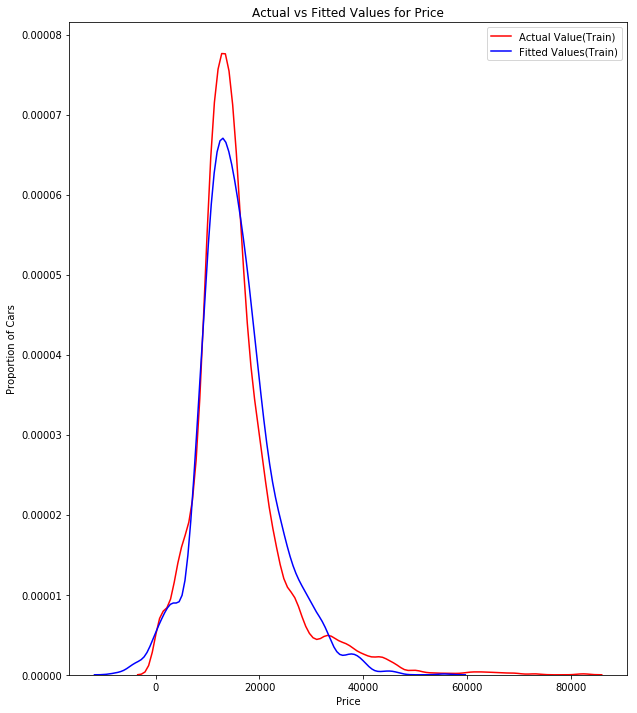

In [93]:
plt.figure(figsize=(10, 12))


ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value(Train)")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values(Train)" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

Distribution plot between test data and predicted data

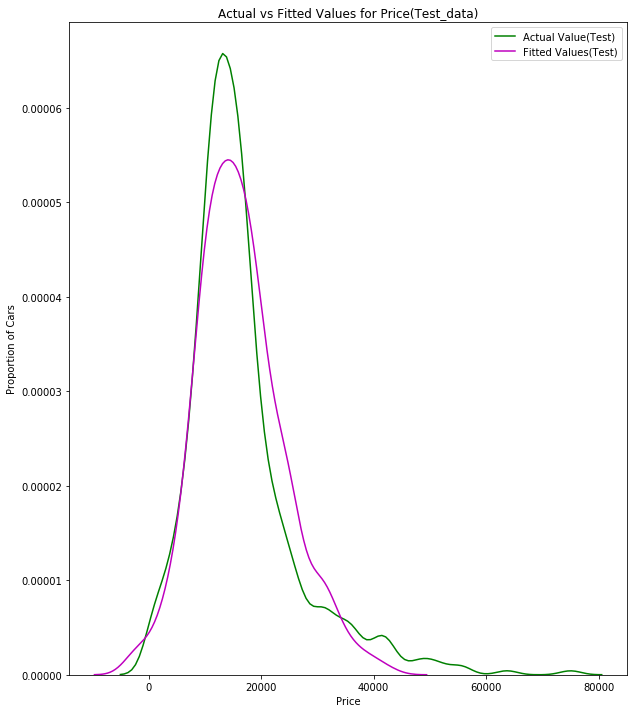

In [165]:
plt.figure(figsize=(10, 12))


ax2 = sns.distplot(y_test, hist=False, color="g", label="Actual Value(Test)")
sns.distplot(yhat_test, hist=False, color="m", label="Fitted Values(Test)", ax=ax2)


plt.title('Actual vs Fitted Values for Price(Test_data)')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

The predicted values are more than expected for higher prices and that pattern kept on going.

model_2 : polynomial regression

In [94]:
lm_2 = LinearRegression()
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)    
lm_2.fit(x_train_pr, y_train)

print('The R-square for prediction on test data: ', lm_2.score(x_test_pr,y_test))

The R-square for prediction on test data:  -48.24927413031234


R-squared value is negative which indicates the fit is actually worse than fitting a straight line so this is worse than linear regression.


model_3 : Ridge Regression

In [95]:
pr=PolynomialFeatures(degree=2)
x_train_pr_ridge=pr.fit_transform(x_train)
x_test_pr_ridge=pr.fit_transform(x_test)

In [96]:
RigeModel=Ridge(alpha=0.1)
RigeModel.fit(x_train_pr, y_train)

C:\Users\Welcome\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.423100e-26
  overwrite_a=True).T


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

# 6. Model Predictions(Ridge Regression)

In [97]:
yhat_rid = RigeModel.predict(x_test_pr)

In [102]:
pd.DataFrame(yhat_rid).to_csv("Predicted_Values.csv")

In [98]:
RigeModel.score(x_test_pr_ridge, y_test)

0.8301400022156428

In [99]:
RigeModel.score(x_train_pr_ridge, y_train)

0.8517594846848306

# 7.Model Evaluation(Ridge Regression)

Distribution plot between test data and predicted data

C:\Users\Welcome\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


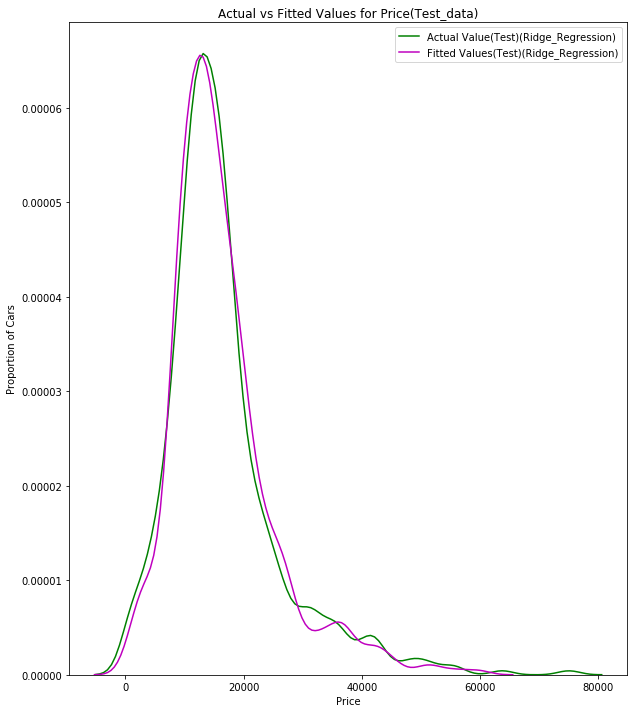

In [100]:
plt.figure(figsize=(10, 12))


ax3 = sns.distplot(y_test, hist=False, color="g", label="Actual Value(Test)(Ridge_Regression)")
sns.distplot(yhat_rid, hist=False, color="m", label="Fitted Values(Test)(Ridge_Regression)", ax=ax3)


plt.title('Actual vs Fitted Values for Price(Test_data)')
plt.xlabel('Price')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()